`uv pip install ipykernel git+https://github.com/dirkgr/plotdevice.git`

In [1]:
from plotdevice import WandbRunBase, _wandb_api
from typing import List
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.ticker as ticker

wandb: [wandb.Api()] Loaded credentials for https://api.wandb.ai from WANDB_API_KEY.


In [2]:
class WandbRun(WandbRunBase):
    @staticmethod
    def list_groups(entity: str, project: str) -> List[str]:
        """List all unique groups in the specified entity/project."""
        runs = _wandb_api.runs(path=f"{entity}/{project}")
        groups = set()
        for run in runs:
            if run.group:
                groups.add(run.group)
        return sorted(list(groups))

    @staticmethod
    def list_run_names(entity: str, project: str) -> List[str]:
        """List all unique run names (display names) in the specified entity/project."""
        runs = _wandb_api.runs(path=f"{entity}/{project}")
        names = set()
        for run in runs:
            if run.display_name:
                names.add(run.display_name)
        return sorted(list(names))

    @property
    def has_finished_run(self) -> bool:
        """Check if at least one of the runs is finished."""
        return any(run.state == "finished" for run in self.runs)

In [3]:
# Extract entity and project from URL
# URL: https://wandb.ai/ai2-llm/olmo3-baseline-ladder
entity = "ai2-llm"
project = "ri-olmo"

In [4]:
# This cell was incorrectly placed - see the cell after the original plot for the filtered version
pass

In [5]:
groups_list = WandbRun.list_groups(entity, project)
groups_list

['ri-olmo-v1-1.3b-4xC',
 'ri-olmo-v1-1p3b-1xC',
 'ri-olmo-v1-1p3b-4xC',
 'ri-olmo-v1-260m-1xC',
 'ri-olmo-v1-260m-2xC',
 'ri-olmo-v1-260m-4xC',
 'ri-olmo-v1-260m-8xC',
 'ri-olmo-v1-260m-8xC-localrepro2',
 'ri-olmo-v1-2b-4xC',
 'ri-olmo-v1-4b-4xC',
 'ri-olmo-v1-709m-1xC',
 'ri-olmo-v1-709m-2xC',
 'ri-olmo-v1-709m-4xC',
 'ri-olmo-v1-709m-8xC',
 'ri-olmo-v1-8b-4xC',
 'ri-olmo-v1-batchwup-260m-4xC',
 'ri-olmo-v1-batchwup-709m-4xC',
 'ri-olmo-v1-batchwup2-1p3b-4xC',
 'ri-olmo-v1-batchwup2-260m-4xC',
 'ri-olmo-v1-batchwup2-2b-4xC',
 'ri-olmo-v1-batchwup2-709m-4xC',
 'ri-olmo-v1-batchwup3-1p3b-4xC',
 'ri-olmo-v1-batchwup3-260m-4xC',
 'ri-olmo-v1-batchwup3-2b-4xC',
 'ri-olmo-v1-batchwup3-709m-4xC',
 'ri-olmo-v1-canonab_noqksilu-260m-1xC',
 'ri-olmo-v1-conv1d-1p3b-1xC',
 'ri-olmo-v1-conv1d-260m-1xC',
 'ri-olmo-v1-conv1d-709m-1xC',
 'ri-olmo-v1-conv1d-gate-1p3b-4xC',
 'ri-olmo-v1-conv1d_gate-1p3b-1xC',
 'ri-olmo-v1-conv1d_gate-260m-1xC',
 'ri-olmo-v1-conv1d_gate-260m-4xC',
 'ri-olmo-v1-conv1d_ga

In [6]:
import re


def parse_group_name(group_name: str) -> tuple[str | None, str, str]:
    """
    Parse a group name to extract (experiment_name, model_size, chinchilla_multiple).

    Examples:
        'ri-olmo-v1-1.3b-4xC' -> (None, '1.3b', '4xC')
        'ri-olmo-v1-gdn-260m-4xC' -> ('gdn', '260m', '4xC')
        'ri-olmo-v1-steplaw-param-correction-1.3b-4xC' -> ('steplaw-param-correction', '1.3b', '4xC')
    """
    # Remove the 'ri-olmo-v1-' prefix
    if group_name.startswith("ri-olmo-v1-"):
        remaining = group_name[len("ri-olmo-v1-") :]
    else:
        remaining = group_name

    # Extract chinchilla multiple from the end (e.g., '4xC', '8xC')
    chinchilla_match = re.search(r"(\d+)xC$", remaining)
    if not chinchilla_match:
        raise ValueError(f"Could not parse chinchilla multiple from: {group_name}")
    chinchilla_multiple = chinchilla_match.group(1) + "xC"
    remaining = remaining[: chinchilla_match.start()].rstrip("-")

    # Known model sizes
    model_sizes = ["260m", "709m", "1.3b", "1p3b", "2b", "4b", "8b", "15b", "34b", "65b"]

    # Find model size in the remaining string
    model_size = None
    for size in model_sizes:
        # Use word boundaries to avoid partial matches
        pattern = r"(?:^|-)" + re.escape(size) + r"(?:-|$)"
        if re.search(pattern, remaining, re.IGNORECASE):
            model_size = size.lower()
            # Remove model size from remaining
            remaining = re.sub(pattern, "", remaining, flags=re.IGNORECASE).strip("-")
            break

    if not model_size:
        raise ValueError(f"Could not parse model size from: {group_name}")

    # Normalize 1p3b to 1.3b
    if model_size == "1p3b":
        model_size = "1.3b"

    # Whatever is left is the experiment name (or None if empty)
    experiment_name = remaining if remaining else None

    return (experiment_name, model_size, chinchilla_multiple)


# Store runs in a DataFrame for easy slicing and querying
runs_data = []

# Parse and store all runs
for group in groups_list:
    try:
        experiment_name, model_size, chinchilla_multiple = parse_group_name(group)
    except ValueError:
        print(f"Skipping group: {group} due to parsing error")
        continue

    runs = WandbRun.by_group(entity, project, group, name=group)
    runs_data.append(
        {
            "experiment_name": experiment_name,
            "model_size": model_size,
            "chinchilla_multiple": chinchilla_multiple,
            "group_name": group,
            "runs": runs,
        }
    )

# Create DataFrame
runs_df = pd.DataFrame(runs_data)

# Set experiment_name to 'baseline' instead of None for easier querying
runs_df["experiment_name"] = runs_df["experiment_name"].fillna("v1-baseline")

# Display summary
print(f"Loaded {len(runs_df)} run groups")
print(f"\nExperiments: {sorted(runs_df['experiment_name'].unique())}")
print(f"Model sizes: {sorted(runs_df['model_size'].unique())}")
print(f"Chinchilla multiples: {sorted(runs_df['chinchilla_multiple'].unique())}")
print(f"\nDataFrame shape: {runs_df.shape}")
print("\nFirst few rows:")
runs_df.head()


Skipping group: ri-olmo-v1-260m-8xC-localrepro2 due to parsing error
Skipping group: ri-olmo-v1-instancefilter-260m-4xC-localrepro due to parsing error
Skipping group: ri-olmo-v1-instancefilter-260m-4xC-localrepro2 due to parsing error
Skipping group: ri-olmo-v1-instancefilter-260m-4xC-localrepro3 due to parsing error
Loaded 139 run groups

Experiments: ['batchwup', 'batchwup2', 'batchwup3', 'canonab_noqksilu', 'conv1d', 'conv1d-gate', 'conv1d_gate', 'conv1d_gate_noglobal', 'conv1d_gate_silu', 'conv1d_nosilu', 'conv1d_qknosilu', 'conv1d_vnorm', 'conv1d_vnormnoscale', 'conv1dx', 'conv3', 'finalanneal', 'gdn', 'gdn-20260203-233932', 'gdn-20260203-234908', 'gdn-expandval', 'gdn-matched-heads', 'gdn-matched-heads-expandv', 'gdn-no-rope', 'gdn-norope', 'headwise-gating', 'instancefilter', 'lr1p11e3', 'lr1p72e3', 'lr5e4', 'muon', 'muon-bsx2', 'normuon', 'ri-olmo-v2', 'ri-olmo-v2-0.5xlr', 'ri-olmo-v2-0p1xlr', 'ri-olmo-v2-0p25xlr', 'ri-olmo-v2-0p5xlr', 'ri-olmo-v2-0p75xlr', 'ri-olmo-v2-1p25xlr

,experiment_name,model_size,chinchilla_multiple,group_name,runs
0,v1-baseline,1.3b,4xC,ri-olmo-v1-1.3b-4xC,<__main__.WandbRun object at 0x11a9c0c20>
1,v1-baseline,1.3b,1xC,ri-olmo-v1-1p3b-1xC,<__main__.WandbRun object at 0x11a8fd590>
2,v1-baseline,1.3b,4xC,ri-olmo-v1-1p3b-4xC,<__main__.WandbRun object at 0x11a8fd450>
3,v1-baseline,260m,1xC,ri-olmo-v1-260m-1xC,<__main__.WandbRun object at 0x11a920640>
4,v1-baseline,260m,2xC,ri-olmo-v1-260m-2xC,<__main__.WandbRun object at 0x11a920770>


In [7]:
# Summary and pivot table view
print("Available experiments:")
print(sorted(runs_df["experiment_name"].unique()))

print("\nAvailable model sizes:")
print(sorted(runs_df["model_size"].unique()))

print("\nAvailable chinchilla multiples:")
print(sorted(runs_df["chinchilla_multiple"].unique()))

# Create a pivot table showing what combinations exist
print("\n\nPivot table (experiment × model_size × chinchilla):")
pivot = runs_df.pivot_table(
    index=["experiment_name", "model_size"],
    columns="chinchilla_multiple",
    values="group_name",
    aggfunc="count",
    fill_value=0,
)
print(pivot)

Available experiments:
['batchwup', 'batchwup2', 'batchwup3', 'canonab_noqksilu', 'conv1d', 'conv1d-gate', 'conv1d_gate', 'conv1d_gate_noglobal', 'conv1d_gate_silu', 'conv1d_nosilu', 'conv1d_qknosilu', 'conv1d_vnorm', 'conv1d_vnormnoscale', 'conv1dx', 'conv3', 'finalanneal', 'gdn', 'gdn-20260203-233932', 'gdn-20260203-234908', 'gdn-expandval', 'gdn-matched-heads', 'gdn-matched-heads-expandv', 'gdn-no-rope', 'gdn-norope', 'headwise-gating', 'instancefilter', 'lr1p11e3', 'lr1p72e3', 'lr5e4', 'muon', 'muon-bsx2', 'normuon', 'ri-olmo-v2', 'ri-olmo-v2-0.5xlr', 'ri-olmo-v2-0p1xlr', 'ri-olmo-v2-0p25xlr', 'ri-olmo-v2-0p5xlr', 'ri-olmo-v2-0p75xlr', 'ri-olmo-v2-1p25xlr', 'ri-olmo-v2-1p5xlr', 'ri-olmo-v2-2p5xlr', 'ri-olmo-v2-2xlr', 'ri-olmo-v2-3xlr', 'ri-olmo-v2-deepseek', 'ri-olmo-v2-no-rope', 'ri-olmo-v2-swa-expandq', 'ri-olmo-v2-swa-expandq1p5', 'ri-olmo-v2-swa-expandq1p5-headwisegate', 'ri-olmo-v2-swa-expandq2', 'ri-olmo-v2-swa-expandq2-headwisegate', 'steplaw-param-correction', 'v1-baseline'

In [8]:
import matplotlib.pyplot as plt

# Collect data from all runs
x_metric = "throughput/total petaflops"
y_metric = "eval/lm/c4_en-validation/CE loss"

data_points = []

for idx, row in tqdm(runs_df.iterrows(), total=len(runs_df)):
    run = row["runs"]
    experiment_name = row["experiment_name"]
    model_size = row["model_size"]
    chinchilla_multiple = row["chinchilla_multiple"]

    is_finished = run.has_finished_run
    ts_x = run.get_time_series(x_metric)
    ts_y = run.get_time_series(y_metric)

    if len(ts_x.ys) > 0 and len(ts_y.ys) > 0:
        # Get the final values
        final_x = ts_x.ys[-1]
        final_y = ts_y.ys[-1]

        data_points.append(
            {
                x_metric: final_x,
                y_metric: final_y,
                "experiment": experiment_name,
                "model_size": model_size,
                "chinchilla_multiple": chinchilla_multiple,
                "group_name": row["group_name"],
                "is_finished": is_finished,
            }
        )


# Create DataFrame from collected points
plot_df = pd.DataFrame(data_points)

print(f"Collected {len(plot_df)} data points")
print("\nData points:")
plot_df

100%|██████████| 139/139 [07:39<00:00,  3.31s/it]

Collected 127 data points

Data points:


,throughput/total petaflops,eval/lm/c4_en-validation/CE loss,experiment,model_size,chinchilla_multiple,group_name,is_finished
0,797575.687500,2.861509,v1-baseline,1.3b,4xC,ri-olmo-v1-1.3b-4xC,True
1,797575.687500,2.832200,v1-baseline,1.3b,4xC,ri-olmo-v1-1p3b-4xC,True
2,7650.808594,3.452272,v1-baseline,260m,1xC,ri-olmo-v1-260m-1xC,True
3,15301.037109,3.372547,v1-baseline,260m,2xC,ri-olmo-v1-260m-2xC,True
4,30602.460938,3.319745,v1-baseline,260m,4xC,ri-olmo-v1-260m-4xC,True
...,...,...,...,...,...,...,...
122,28177.650391,3.280885,ri-olmo-v2-swa-expandq2,260m,4xC,ri-olmo-v2-swa-expandq2-260m-4xC,True
123,238295.187500,3.034543,ri-olmo-v2-swa-expandq2,709m,4xC,ri-olmo-v2-swa-expandq2-709m-4xC,False
124,163006.296875,3.127938,ri-olmo-v2-swa-expandq2-headwisegate,1.3b,4xC,ri-olmo-v2-swa-expandq2-headwisegate-1.3b-4xC,False
125,25494.591797,3.317377,ri-olmo-v2-swa-expandq2-headwisegate,260m,4xC,ri-olmo-v2-swa-expandq2-headwisegate-260m-4xC,True


/var/folders/ht/x1v1b_5x5d78r4153tx00yxw0000gp/T/ipykernel_99988/2226435048.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20" if len(experiments) <= 20 else "hsv")


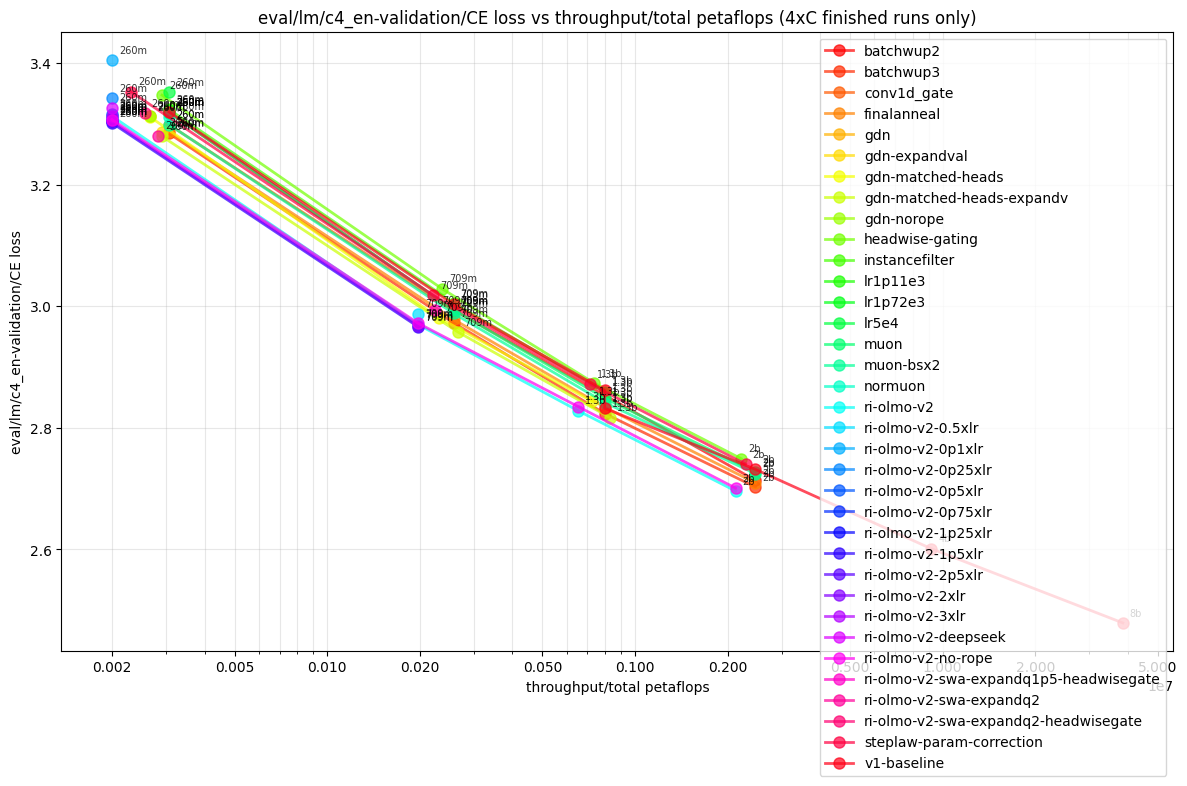

In [9]:
# Filter to only 4xC runs that are finished
plot_df_4xc = plot_df[
    (plot_df["chinchilla_multiple"] == "4xC") & (plot_df["is_finished"] == True)
].copy()


# Convert model sizes to numeric for sorting (e.g., '260m' -> 0.26, '1.3b' -> 1.3, '2b' -> 2, etc.)
def model_size_to_numeric(size):
    if size.endswith("m"):
        return float(size[:-1]) / 1000  # Convert millions to billions
    elif size.endswith("b"):
        return float(size[:-1])
    else:
        return 0.0


plot_df_4xc["model_size_numeric"] = plot_df_4xc["model_size"].apply(model_size_to_numeric)
plot_df_4xc = plot_df_4xc.sort_values(["experiment", "model_size_numeric"])

# Create the plot
plt.figure(figsize=(12, 8))

# Get unique experiments and assign colors
experiments = plot_df_4xc["experiment"].unique()
# Use a colormap that can generate distinct colors for any number of experiments

cmap = plt.cm.get_cmap("tab20" if len(experiments) <= 20 else "hsv")
colors = cmap(np.linspace(0, 1, len(experiments)))

# Plot lines and points for each experiment
for exp_idx, exp in enumerate(experiments):
    exp_data = plot_df_4xc[plot_df_4xc["experiment"] == exp]

    # Plot line connecting points
    plt.plot(
        exp_data[x_metric],
        exp_data[y_metric],
        marker="o",
        markersize=8,
        linewidth=2,
        label=exp,
        color=colors[exp_idx],
        alpha=0.7,
    )

    # Add annotations for each point
    for idx, row in exp_data.iterrows():
        plt.annotate(
            row["model_size"],
            (row[x_metric], row[y_metric]),
            fontsize=7,
            alpha=0.8,
            xytext=(5, 5),
            textcoords="offset points",
        )

# Add labels
plt.xlabel(x_metric)
plt.ylabel(y_metric)
plt.title(f"{y_metric} vs {x_metric} (4xC finished runs only)")
plt.xscale("log")

ax = plt.gca()
# Get the current x-axis limits
x_min, x_max = ax.get_xlim()
# Generate more tick positions
x_min_log = np.floor(np.log10(x_min))
x_max_log = np.ceil(np.log10(x_max))
# Create ticks at powers of 10 and intermediate values
major_ticks = []
for exp in range(int(x_min_log), int(x_max_log) + 1):
    major_ticks.append(10**exp)
    major_ticks.append(2 * 10**exp)
    major_ticks.append(5 * 10**exp)
major_ticks = [t for t in major_ticks if x_min <= t <= x_max]
ax.set_xticks(major_ticks)
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(ticker.NullFormatter())

plt.grid(True, alpha=0.3, which="both")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

/var/folders/ht/x1v1b_5x5d78r4153tx00yxw0000gp/T/ipykernel_99988/3997749646.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20" if len(experiments) <= 20 else "hsv")


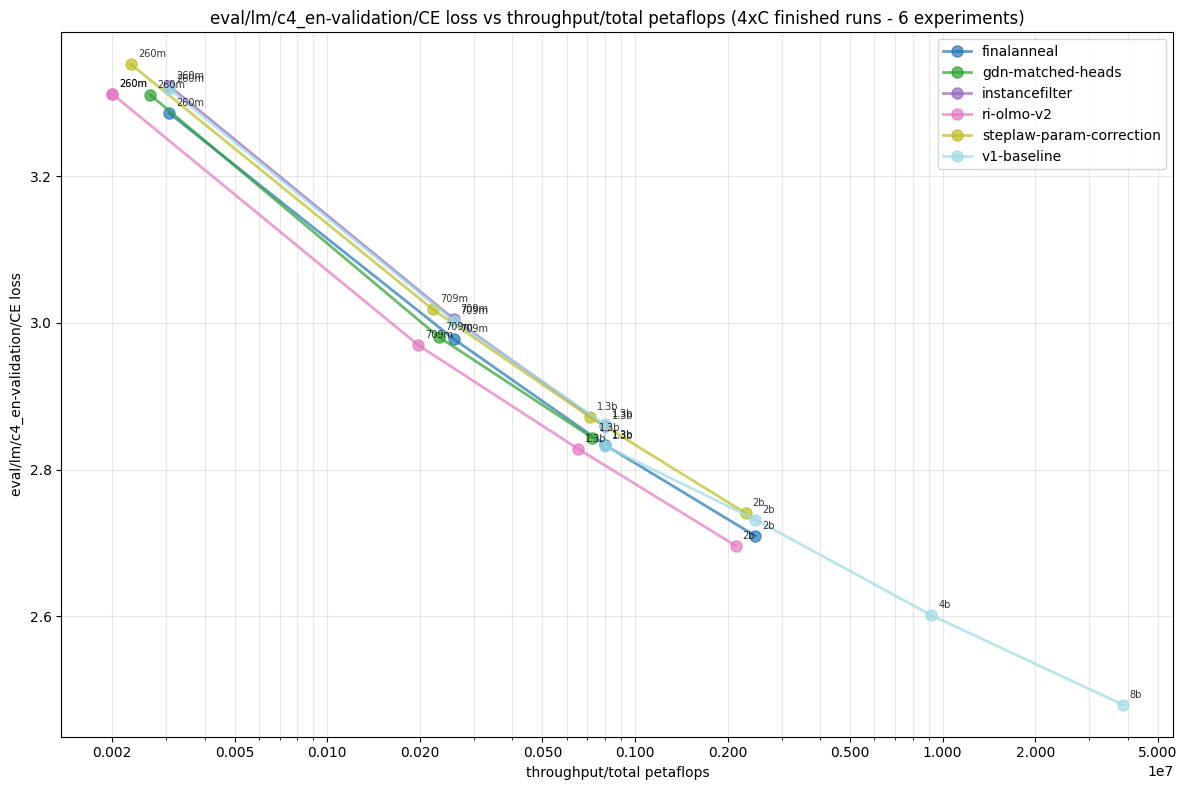

In [10]:
# Filter to only 4xC runs that are finished
plot_df_4xc = plot_df[
    (plot_df["chinchilla_multiple"] == "4xC") & (plot_df["is_finished"] == True)
].copy()

# Specify which experiments to plot
# Change this list to include the experiment names (without model sizes)
# Examples: "muon", "gdn", "v1-baseline", "headwise-gating", etc.
# experiments_to_plot = [
#     "v1-baseline",
#     "gdn-matched-heads",
#     "gdn-matched-heads-expandv",
#     "conv1d_gate",
# ]
# experiments_to_plot = ["v1-baseline", "muon", "muon-bsx2"]
experiments_to_plot = [
    "v1-baseline",
    "gdn-matched-heads",
    "instancefilter",
    "steplaw-param-correction",
    "finalanneal",
    "ri-olmo-v2",
]

# Filter to only the selected experiments
plot_df_filtered = plot_df_4xc[plot_df_4xc["experiment"].isin(experiments_to_plot)].copy()


# Convert model sizes to numeric for sorting (e.g., '260m' -> 0.26, '1.3b' -> 1.3, '2b' -> 2, etc.)
def model_size_to_numeric(size):
    if size.endswith("m"):
        return float(size[:-1]) / 1000  # Convert millions to billions
    elif size.endswith("b"):
        return float(size[:-1])
    else:
        return 0.0


plot_df_filtered["model_size_numeric"] = plot_df_filtered["model_size"].apply(model_size_to_numeric)
plot_df_filtered = plot_df_filtered.sort_values(["experiment", "model_size_numeric"])

# Create the plot
plt.figure(figsize=(12, 8))

# Get unique experiments
experiments = plot_df_filtered["experiment"].unique()
# Use a colormap that can generate distinct colors for any number of experiments
cmap = plt.cm.get_cmap("tab20" if len(experiments) <= 20 else "hsv")
colors = cmap(np.linspace(0, 1, len(experiments)))

# Plot lines and points for each experiment
for exp_idx, exp in enumerate(experiments):
    exp_data = plot_df_filtered[plot_df_filtered["experiment"] == exp]

    # Plot line connecting points
    plt.plot(
        exp_data[x_metric],
        exp_data[y_metric],
        marker="o",
        markersize=8,
        linewidth=2,
        label=exp,
        color=colors[exp_idx],
        alpha=0.7,
    )

    # Add annotations for each point
    for idx, row in exp_data.iterrows():
        plt.annotate(
            row["model_size"],
            (row[x_metric], row[y_metric]),
            fontsize=7,
            alpha=0.8,
            xytext=(5, 5),
            textcoords="offset points",
        )

# Add labels
plt.xlabel(x_metric)
plt.ylabel(y_metric)
experiment_names_str = ", ".join(experiments_to_plot)
plt.title(f"{y_metric} vs {x_metric} (4xC finished runs - {len(experiments_to_plot)} experiments)")
plt.xscale("log")

ax = plt.gca()
# Get the current x-axis limits
x_min, x_max = ax.get_xlim()
# Generate more tick positions
x_min_log = np.floor(np.log10(x_min))
x_max_log = np.ceil(np.log10(x_max))
# Create ticks at powers of 10 and intermediate values
major_ticks = []
for exp in range(int(x_min_log), int(x_max_log) + 1):
    major_ticks.append(10**exp)
    major_ticks.append(2 * 10**exp)
    major_ticks.append(5 * 10**exp)
major_ticks = [t for t in major_ticks if x_min <= t <= x_max]
ax.set_xticks(major_ticks)
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(ticker.NullFormatter())

plt.grid(True, alpha=0.3, which="both")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

/var/folders/ht/x1v1b_5x5d78r4153tx00yxw0000gp/T/ipykernel_99988/489204042.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20" if len(experiments) <= 20 else "hsv")


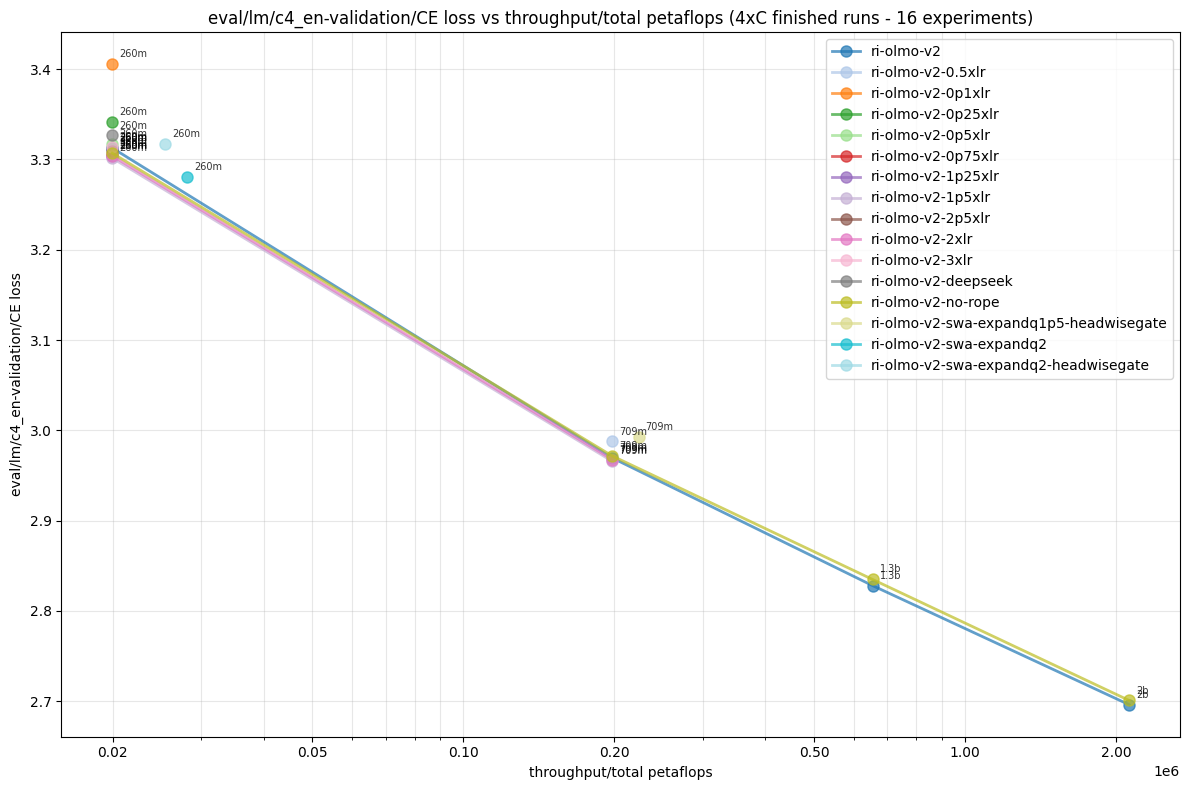

In [11]:
# Filter to only 4xC runs that are finished
plot_df_4xc = plot_df[
    (plot_df["chinchilla_multiple"] == "4xC") & (plot_df["is_finished"] == True)
].copy()

# Specify which experiments to plot
# Change this list to include the experiment names (without model sizes)
# Examples: "muon", "gdn", "v1-baseline", "headwise-gating", etc.
# Get all experiments that start with ri-olmo-v2
experiments_to_plot = [
    exp for exp in plot_df_4xc["experiment"].unique() if exp.startswith("ri-olmo-v2")
]

# Filter to only the selected experiments
plot_df_filtered = plot_df_4xc[plot_df_4xc["experiment"].isin(experiments_to_plot)].copy()


# Convert model sizes to numeric for sorting (e.g., '260m' -> 0.26, '1.3b' -> 1.3, '2b' -> 2, etc.)
def model_size_to_numeric(size):
    if size.endswith("m"):
        return float(size[:-1]) / 1000  # Convert millions to billions
    elif size.endswith("b"):
        return float(size[:-1])
    else:
        return 0.0


plot_df_filtered["model_size_numeric"] = plot_df_filtered["model_size"].apply(model_size_to_numeric)
plot_df_filtered = plot_df_filtered.sort_values(["experiment", "model_size_numeric"])

# Create the plot
plt.figure(figsize=(12, 8))

# Get unique experiments
experiments = plot_df_filtered["experiment"].unique()
# Use a colormap that can generate distinct colors for any number of experiments
cmap = plt.cm.get_cmap("tab20" if len(experiments) <= 20 else "hsv")
colors = cmap(np.linspace(0, 1, len(experiments)))

# Plot lines and points for each experiment
for exp_idx, exp in enumerate(experiments):
    exp_data = plot_df_filtered[plot_df_filtered["experiment"] == exp]

    # Plot line connecting points
    plt.plot(
        exp_data[x_metric],
        exp_data[y_metric],
        marker="o",
        markersize=8,
        linewidth=2,
        label=exp,
        color=colors[exp_idx],
        alpha=0.7,
    )

    # Add annotations for each point
    for idx, row in exp_data.iterrows():
        plt.annotate(
            row["model_size"],
            (row[x_metric], row[y_metric]),
            fontsize=7,
            alpha=0.8,
            xytext=(5, 5),
            textcoords="offset points",
        )

# Add labels
plt.xlabel(x_metric)
plt.ylabel(y_metric)
experiment_names_str = ", ".join(experiments_to_plot)
plt.title(f"{y_metric} vs {x_metric} (4xC finished runs - {len(experiments_to_plot)} experiments)")
plt.xscale("log")

ax = plt.gca()
# Get the current x-axis limits
x_min, x_max = ax.get_xlim()
# Generate more tick positions
x_min_log = np.floor(np.log10(x_min))
x_max_log = np.ceil(np.log10(x_max))
# Create ticks at powers of 10 and intermediate values
major_ticks = []
for exp in range(int(x_min_log), int(x_max_log) + 1):
    major_ticks.append(10**exp)
    major_ticks.append(2 * 10**exp)
    major_ticks.append(5 * 10**exp)
major_ticks = [t for t in major_ticks if x_min <= t <= x_max]
ax.set_xticks(major_ticks)
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(ticker.NullFormatter())

plt.grid(True, alpha=0.3, which="both")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

/var/folders/ht/x1v1b_5x5d78r4153tx00yxw0000gp/T/ipykernel_99988/3137583737.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20" if len(experiments) <= 20 else "hsv")


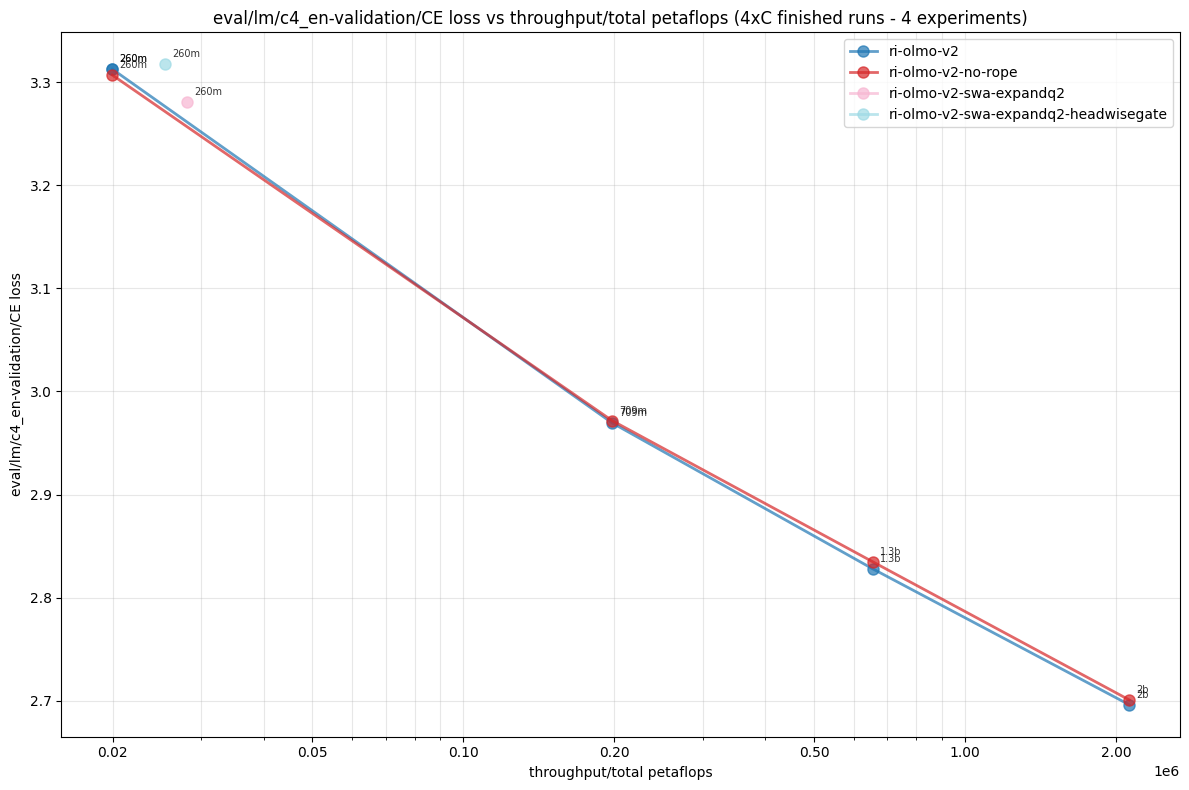

In [14]:
# Filter to only 4xC runs that are finished
plot_df_4xc = plot_df[
    (plot_df["chinchilla_multiple"] == "4xC") & (plot_df["is_finished"] == True)
].copy()

# Specify which experiments to plot
# Change this list to include the experiment names (without model sizes)
# Examples: "muon", "gdn", "v1-baseline", "headwise-gating", etc.
experiments_to_plot = [
    "ri-olmo-v2",
    "ri-olmo-v2-no-rope",
    "ri-olmo-v2-swa-expandq2",
    "ri-olmo-v2-swa-expandq2-headwisegate",
]

# Filter to only the selected experiments
plot_df_filtered = plot_df_4xc[plot_df_4xc["experiment"].isin(experiments_to_plot)].copy()


# Convert model sizes to numeric for sorting (e.g., '260m' -> 0.26, '1.3b' -> 1.3, '2b' -> 2, etc.)
def model_size_to_numeric(size):
    if size.endswith("m"):
        return float(size[:-1]) / 1000  # Convert millions to billions
    elif size.endswith("b"):
        return float(size[:-1])
    else:
        return 0.0


plot_df_filtered["model_size_numeric"] = plot_df_filtered["model_size"].apply(model_size_to_numeric)
plot_df_filtered = plot_df_filtered.sort_values(["experiment", "model_size_numeric"])

# Create the plot
plt.figure(figsize=(12, 8))

# Get unique experiments
experiments = plot_df_filtered["experiment"].unique()
# Use a colormap that can generate distinct colors for any number of experiments
cmap = plt.cm.get_cmap("tab20" if len(experiments) <= 20 else "hsv")
colors = cmap(np.linspace(0, 1, len(experiments)))

# Plot lines and points for each experiment
for exp_idx, exp in enumerate(experiments):
    exp_data = plot_df_filtered[plot_df_filtered["experiment"] == exp]

    # Plot line connecting points
    plt.plot(
        exp_data[x_metric],
        exp_data[y_metric],
        marker="o",
        markersize=8,
        linewidth=2,
        label=exp,
        color=colors[exp_idx],
        alpha=0.7,
    )

    # Add annotations for each point
    for idx, row in exp_data.iterrows():
        plt.annotate(
            row["model_size"],
            (row[x_metric], row[y_metric]),
            fontsize=7,
            alpha=0.8,
            xytext=(5, 5),
            textcoords="offset points",
        )

# Add labels
plt.xlabel(x_metric)
plt.ylabel(y_metric)
experiment_names_str = ", ".join(experiments_to_plot)
plt.title(f"{y_metric} vs {x_metric} (4xC finished runs - {len(experiments_to_plot)} experiments)")
plt.xscale("log")

ax = plt.gca()
# Get the current x-axis limits
x_min, x_max = ax.get_xlim()
# Generate more tick positions
x_min_log = np.floor(np.log10(x_min))
x_max_log = np.ceil(np.log10(x_max))
# Create ticks at powers of 10 and intermediate values
major_ticks = []
for exp in range(int(x_min_log), int(x_max_log) + 1):
    major_ticks.append(10**exp)
    major_ticks.append(2 * 10**exp)
    major_ticks.append(5 * 10**exp)
major_ticks = [t for t in major_ticks if x_min <= t <= x_max]
ax.set_xticks(major_ticks)
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(ticker.NullFormatter())

plt.grid(True, alpha=0.3, which="both")
plt.legend(loc="best")

plt.tight_layout()
plt.show()